In [1]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
!pip install pytorch-lightning
!pip install albumentations
!pip install gdown
!pip install torchvision       

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-r61zaets
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-r61zaets
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 1fa49d0953708c0a61ab11c5cc4052d20909a9bc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 438.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.0-py3-none-any.whl size=102059 sha256=61ca9cd747118f90069124c49a11c535a061e383c2903970161fb01dd89d43c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-my__p0bj/wheels/fa/c5/

In [2]:
import gdown

# https://drive.google.com/file/d/1-6Bg4PgGGaU5MIOPGVe-fzXIMg1yVKxv/view?usp=sharing

url='https://drive.google.com/uc?id=1-6Bg4PgGGaU5MIOPGVe-fzXIMg1yVKxv'
output_file_train='Segmentantion.zip'

gdown.download(url, output_file_train, quiet=False)
!unzip Segmentantion.zip

Downloading...
From: https://drive.google.com/uc?id=1-6Bg4PgGGaU5MIOPGVe-fzXIMg1yVKxv
To: /kaggle/working/Segmentantion.zip
100%|██████████| 5.35G/5.35G [09:54<00:00, 8.99MB/s]


Archive:  Segmentantion.zip
   creating: Segmentation_splited/Masks/
  inflating: Segmentation_splited/Masks/image_1585.png  
  inflating: Segmentation_splited/Masks/image_1833.png  
  inflating: Segmentation_splited/Masks/image_1104.png  
  inflating: Segmentation_splited/Masks/image_283.png  
  inflating: Segmentation_splited/Masks/image_1782.png  
  inflating: Segmentation_splited/Masks/image_592.png  
  inflating: Segmentation_splited/Masks/image_158.png  
  inflating: Segmentation_splited/Masks/image_1244.png  
  inflating: Segmentation_splited/Masks/image_1781.png  
  inflating: Segmentation_splited/Masks/image_1731.png  
  inflating: Segmentation_splited/Masks/image_693.png  
  inflating: Segmentation_splited/Masks/image_480.png  
  inflating: Segmentation_splited/Masks/image_605.png  
  inflating: Segmentation_splited/Masks/image_1998.png  
  inflating: Segmentation_splited/Masks/image_1688.png  
  inflating: Segmentation_splited/Masks/image_137.png  
  inflating: Segmentation_

In [3]:
import torch
import torch.utils.data
import albumentations as A
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2
import os

#mode split
class DatasetLoader(torch.utils.data.Dataset):
  def __init__(self,dataset_path: str,mode:str,img_size: int):
    self.dataset_path=dataset_path
    self.mode=mode
    self.img_size=img_size

    self.imgs = list(sorted(os.listdir(os.path.join(self.dataset_path,self.mode, "Images"))))
    self.masks = list(sorted(os.listdir(os.path.join(self.dataset_path, "Masks")))) 
    self.img_size=img_size
  
  def __getitem__(self, idx):

    mask_path=self.imgs[idx].replace('.jpg','.png')
    img_path = os.path.join(self.dataset_path,self.mode,'Images', self.imgs[idx])

    image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # I am still wondering why OpenCV changed to BGR by default
    
    mask_path = os.path.join(self.dataset_path,'Masks', mask_path)
    mask=cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    
    if self.mode=='train':
      heavy_transforms = [
                      A.Resize(self.img_size, self.img_size, interpolation=cv2.INTER_LINEAR, p=1), 
                      A.RandomRotate90(),
                      A.Flip(),
                      A.Transpose(),
                      A.GaussNoise(),
                      A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.7),                    
                      A.OneOf([
                          A.MotionBlur(p=0.2),
                          A.MedianBlur(blur_limit=3, p=0.1),
                          A.Blur(blur_limit=3, p=0.1),
                      ], p=0.5),                    
                      A.OneOf([                        
                          A.IAASharpen(),
                          A.IAAEmboss(),
                          A.RandomBrightnessContrast(),
                      ], p=0.5),
                      A.HueSaturationValue(p=0.3),
                      A.Normalize(
                              mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225],
                          ),
                      ToTensorV2()
                      ]                 
      aug= A.Compose(heavy_transforms ,p=1)                       
      augmented = aug(image=image, mask=mask)
      image,mask= augmented['image'],augmented['mask']
      
    else:
        heavy_transforms = [
                      A.Resize(self.img_size, self.img_size, interpolation=cv2.INTER_LINEAR, p=1), 
                      A.Normalize(
                              mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225],
                          ),
                      ToTensorV2()
                      ]                 
        aug= A.Compose(heavy_transforms ,p=1)                       
        augmented = aug(image=image, mask=mask)    
        image,mask= augmented['image'],augmented['mask']   
    
    if mask.ndim!=4:
      mask=torch.unsqueeze(mask, dim=0)
      
    mask=mask/torch.max(mask)
    mask=torch.tensor(mask, dtype=torch.uint8)
    sample = dict(image=image, mask=mask)

    return sample

  def __len__(self):
    return len(self.imgs)    

   

In [4]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

class Segmentation_custom(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # for image segmentation dice loss could be the best first choice
        # self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE)

    def forward(self, image):
        # normalize image here
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4
        

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [5]:
#mODE SPLIT
from torch.utils.data import DataLoader
import torch.utils.data as data


train_set=DatasetLoader('/kaggle/working/Segmentation_splited/','train',224)
valid_set=DatasetLoader('/kaggle/working/Segmentation_splited/','val',224)
test_set=DatasetLoader('/kaggle/working/Segmentation_splited/','test',224)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=64, shuffle=False)
test_laoder = DataLoader(test_set, batch_size=64, shuffle=False)

In [6]:
pl.seed_everything(42) 
torch.manual_seed(42)

model = Segmentation_custom("Unet", "mit_b0", in_channels=3, out_classes=1)

trainer = pl.Trainer(
    gpus=1, 
    max_epochs=20,
)

trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=val_loader,
)

Downloading: "https://github.com/qubvel/segmentation_models.pytorch/releases/download/v0.0.2/mit_b0.pth" to /root/.cache/torch/hub/checkpoints/mit_b0.pth


  0%|          | 0.00/13.7M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1898: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:233: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:176: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:233: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:176: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [8]:
!cp -v ./lightning_logs/version_0/checkpoints/ep* /kaggle/working/mix_transfomer_unet.ckpt

'./lightning_logs/version_0/checkpoints/epoch=19-step=520.ckpt' -> '/kaggle/working/mix_transfomer_unet.ckpt'


# Evaluation

In [9]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [10]:
!wget https://media.istockphoto.com/videos/aerial-view-forest-fire-busuanga-palawan-philippines-video-id684083112?s=640x640
!mv ./aerial-view-forest-fire-busuanga-palawan-philippines-video-id684083112?s=640x640 foto.jpg

!wget https://c1.wallpaperflare.com/preview/721/725/166/drone-view-aerial-view-sea-ocean.jpg
!mv drone-view-aerial-view-sea-ocean.jpg laut.jpg

!wget https://media.istockphoto.com/videos/4k-aerial-view-and-zoom-out-of-forest-fire-in-sunset-time-video-id932420522?s=640x640
!mv 4k-aerial-view-and-zoom-out-of-forest-fire-in-sunset-time-video-id932420522?s=640x640 api2.jpg    

--2022-09-15 13:12:56--  https://media.istockphoto.com/videos/aerial-view-forest-fire-busuanga-palawan-philippines-video-id684083112?s=640x640
Resolving media.istockphoto.com (media.istockphoto.com)... 13.35.7.49, 13.35.7.35, 13.35.7.75, ...
Connecting to media.istockphoto.com (media.istockphoto.com)|13.35.7.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42773 (42K) [image/jpeg]
Saving to: ‘aerial-view-forest-fire-busuanga-palawan-philippines-video-id684083112?s=640x640’

aerial-view-forest- 100%[===================>]  41.77K  --.-KB/s    in 0.1s    

2022-09-15 13:12:57 (289 KB/s) - ‘aerial-view-forest-fire-busuanga-palawan-philippines-video-id684083112?s=640x640’ saved [42773/42773]

--2022-09-15 13:12:59--  https://c1.wallpaperflare.com/preview/721/725/166/drone-view-aerial-view-sea-ocean.jpg
Resolving c1.wallpaperflare.com (c1.wallpaperflare.com)... 104.21.235.72, 104.21.235.71, 2606:4700:3038::6815:eb47, ...
Connecting to c1.wallpaperflare.com (c1.wal

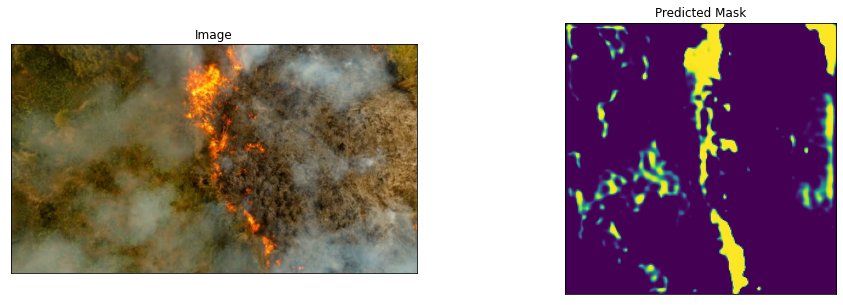

In [13]:
image = cv2.imread('./foto.jpg', cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

heavy_transforms = [
                    A.Resize(224,224, interpolation=cv2.INTER_LINEAR, p=1), 
                    A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                    ToTensorV2()
                    ]  
aug= A.Compose(heavy_transforms ,p=1)                       
augmented = aug(image=image)

img=augmented['image']
# img=img.type(torch.cuda.FloatTensor)

with torch.no_grad():
    model.eval()
    logits = model(img[None,...])
    pr_masks = logits.sigmoid()

visualize(
        image=image, 
        predicted_mask=pr_masks.squeeze().cpu()
    )

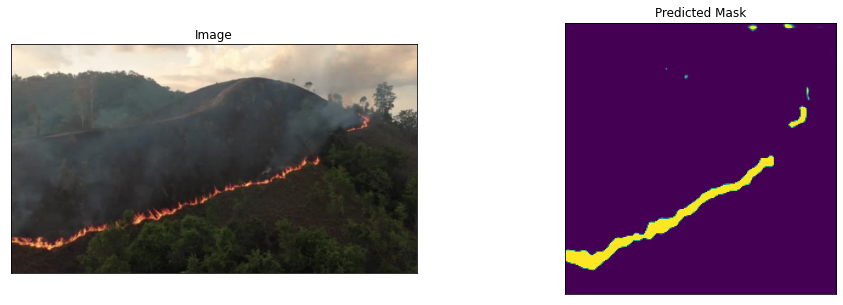

In [14]:
image = cv2.imread('./api2.jpg', cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

heavy_transforms = [
                    A.Resize(224,224, interpolation=cv2.INTER_LINEAR, p=1), 
                    A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                    ToTensorV2()
                    ]  
aug= A.Compose(heavy_transforms ,p=1)                       
augmented = aug(image=image)

img=augmented['image']
# img=img.type(torch.cuda.FloatTensor)

with torch.no_grad():
    model.eval()
    logits = model(img[None,...])
    pr_masks = logits.sigmoid()

visualize(
        image=image, 
        predicted_mask=pr_masks.squeeze().cpu()
    )